# Deep Learning

# Tutorial 18: Hyperparameter Selection (Learning Rate)

In this tutorial, we will cover:

- How to chose the right learning rate

Prerequisites:

- Python, PyTorch, Deep Learning Training, Stochastic Gradient Descent

My contact:

- Niklas Beuter (niklas.beuter@th-luebeck.de)

Course:

- Slides and notebooks will be available at https://lernraum.th-luebeck.de/course/view.php?id=5383

## Expected Outcomes
* Understand how the learning rate effects training
* Select a good learning rate for your training

In [4]:
!pip install torch torchvision matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.2/779.2 MB 13.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 19.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 92.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 82.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 13.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 47.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 67.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 42.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 39.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 40.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━

## PyTorch Learning Rate Schedulers

PyTorch provides several learning rate schedulers that adjust the learning rate during training. This can help improve convergence and model performance. The usage is quite easy. Just define one of the schedulers and use it in addition in your learning function (scheduler.step() adapts your learning rate based on the scheduler).

```
optimizer = optim.SGD(model.parameters(), learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
optimizer.zero_grad()
output = model(data)
loss = criterion(output, target)
loss.backward()
optimizer.step()
if scheduler:
    scheduler.step()
```

### Common Schedulers:

1. **StepLR**: Decays the learning rate of each parameter group by `gamma` every `step_size` epochs.
    ```python
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    ```

2. **MultiStepLR**: Decays the learning rate of each parameter group by `gamma` at milestones (list of epoch indices).
    ```python
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30, 80], gamma=0.1)
    ```

3. **ExponentialLR**: Decays the learning rate of each parameter group by `gamma` every epoch.
    ```python
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    ```

4. **CosineAnnealingLR**: Sets the learning rate of each parameter group using a cosine annealing schedule.
    ```python
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
    ```

5. **LambdaLR**: Sets the learning rate of each parameter group to the initial learning rate times a given function.
    ```python
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.95 ** epoch)
    ```

6. **ReduceLROnPlateau**: Reduces the learning rate when a metric has stopped improving.
    ```python
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')
    ```

Each scheduler can be combined with any optimizer to dynamically adjust the learning rate during training. Below, we will demonstrate different learning rate adaptation techniques using some of these schedulers.

## Let us try schedulers

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

## Setup Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [9]:
# Common Learning Problem: MNIST Classification
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Simple Neural Network
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Training Function
def train_model(model, optimizer, scheduler=None, num_epochs=5):
    criterion = nn.CrossEntropyLoss()
    
    model.train()
    loss_history = []
    lr_history = []

    for epoch in range(num_epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            if scheduler:
                scheduler.step()
                
            loss_history.append(loss.item())
            lr_history.append(optimizer.param_groups[0]['lr'])
            
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')
        
    return loss_history, lr_history

# Plotting Function
def plot_results(lr_hist, loss_hist, title_lr, title_loss):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(lr_hist)
    plt.title(title_lr)
    plt.xlabel('Iteration')
    plt.ylabel('Learning Rate')

    plt.subplot(1, 2, 2)
    plt.plot(loss_hist)
    plt.title(title_loss)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.show()

## Learning rate selection

In the following we will cover how the learning rate effects your training. We will start with a fixed learning rate. In this method, the learning rate remains constant throughout the training process.

Epoch 1/5, Loss: 0.5404
Epoch 2/5, Loss: 0.5679
Epoch 3/5, Loss: 0.1788
Epoch 4/5, Loss: 0.2866
Epoch 5/5, Loss: 0.4116


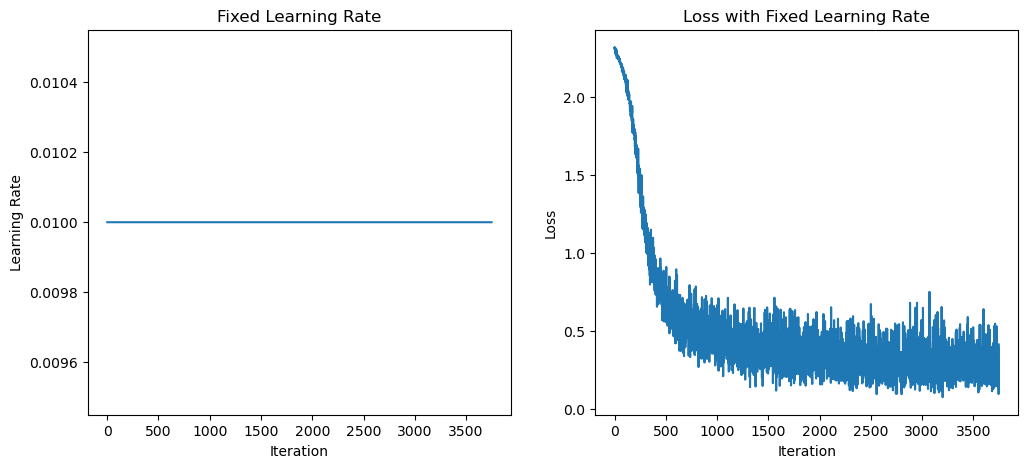

In [19]:
fixed_lr = 0.01
model = SimpleNN().to(device)
optimizer = optim.SGD(model.parameters(), lr=fixed_lr)
fixed_loss, fixed_lr_hist = train_model(model, optimizer)
plot_results(fixed_lr_hist, fixed_loss, 'Fixed Learning Rate', 'Loss with Fixed Learning Rate')

## Adapt your learning rate with steps

Idea: After a specific amount of epochs (here 10,20,30), multiply the learning rate with a constant factor of e.g. 0.1.
$$ lr_{new} = lr_{old} \times \gamma $$

Epoch 1/5, Loss: 0.5144
Epoch 2/5, Loss: 0.4558
Epoch 3/5, Loss: 0.1711
Epoch 4/5, Loss: 0.3107
Epoch 5/5, Loss: 0.3141


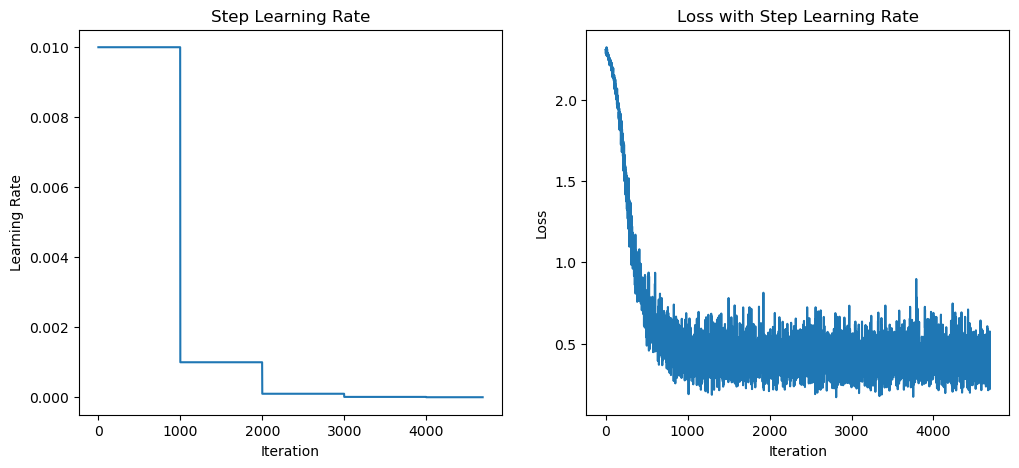

In [12]:
step_lr = 0.01
model = SimpleNN().to(device)
optimizer = optim.SGD(model.parameters(), lr=step_lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.1)
step_loss, step_lr_hist = train_model(model, optimizer, scheduler)
plot_results(step_lr_hist, step_loss, 'Step Learning Rate', 'Loss with Step Learning Rate')

### Cosine Decay
The learning rate follows a cosine curve.
$$ lr = lr_{min} + \frac{1}{2} (lr_{max} - lr_{min}) \left(1 + \cos\left(\frac{T_{cur}}{T_{max}} \pi\right)\right) $$

Epoch 1/5, Loss: 0.3939
Epoch 2/5, Loss: 0.2532
Epoch 3/5, Loss: 0.4313
Epoch 4/5, Loss: 0.3159
Epoch 5/5, Loss: 0.2472


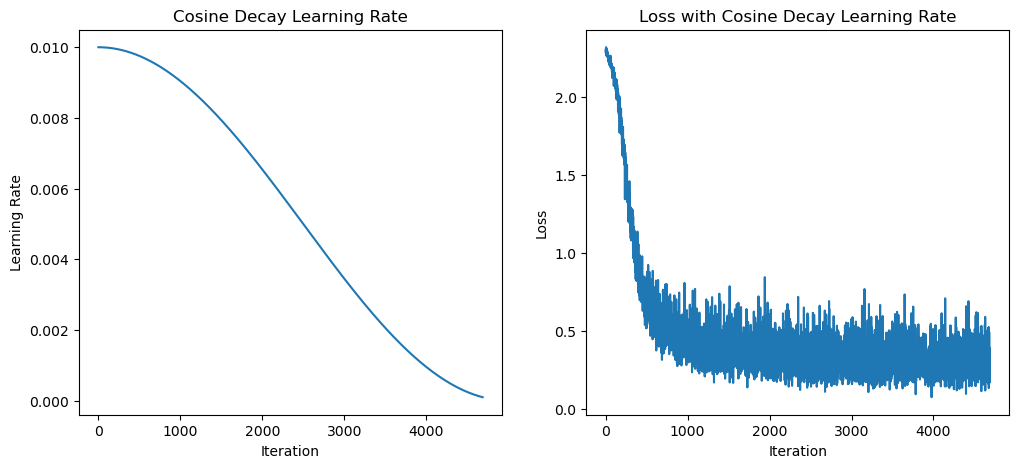

In [14]:
cos_lr = 0.01
model = SimpleNN().to(device)
optimizer = optim.SGD(model.parameters(), lr=cos_lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5000)
cos_loss, cos_lr_hist = train_model(model, optimizer, scheduler)
plot_results(cos_lr_hist, cos_loss, 'Cosine Decay Learning Rate', 'Loss with Cosine Decay Learning Rate')

### Linear Decay
The learning rate decreases linearly over time.
$$ lr = lr_{initial} \times \left(1 - \frac{t}{T}\right) $$

Epoch 1/5, Loss: 0.3050
Epoch 2/5, Loss: 0.1513
Epoch 3/5, Loss: 0.2607
Epoch 4/5, Loss: 0.1678
Epoch 5/5, Loss: 0.3444


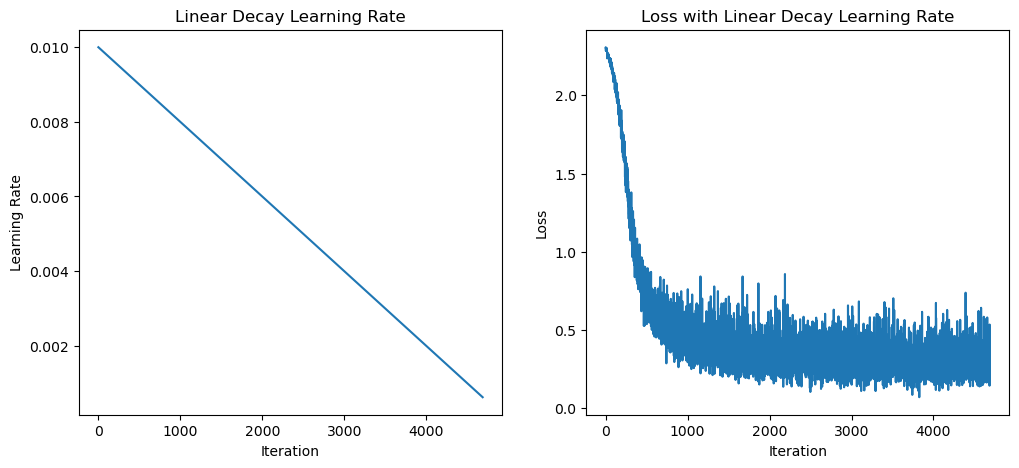

In [15]:
linear_lr = 0.01
model = SimpleNN().to(device)
optimizer = optim.SGD(model.parameters(), lr=linear_lr)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 1 - epoch / 5000)
linear_loss, linear_lr_hist = train_model(model, optimizer, scheduler)
plot_results(linear_lr_hist, linear_loss, 'Linear Decay Learning Rate', 'Loss with Linear Decay Learning Rate')

### Inverse Square Root Decay
The learning rate decreases proportionally to the inverse of the square root of the epoch number.
$$ lr = \frac{lr_{initial}}{\sqrt{epoch}} $$

Epoch 1/5, Loss: 2.1546
Epoch 2/5, Loss: 2.1339
Epoch 3/5, Loss: 2.0455
Epoch 4/5, Loss: 1.9695
Epoch 5/5, Loss: 1.9529


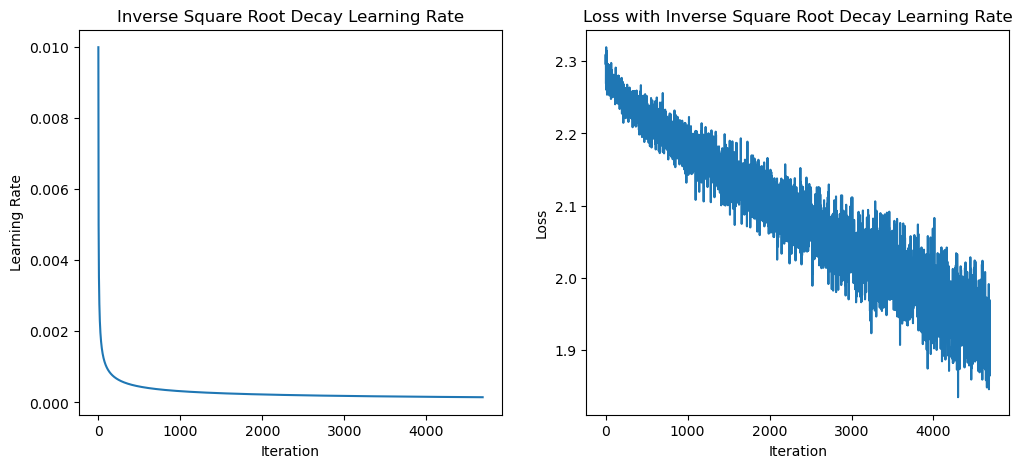

In [16]:
inverse_sqrt_lr = 0.01
model = SimpleNN().to(device)
optimizer = optim.SGD(model.parameters(), lr=inverse_sqrt_lr)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 1 / (epoch ** 0.5) if epoch > 0 else 1)
inverse_sqrt_loss, inverse_sqrt_lr_hist = train_model(model, optimizer, scheduler)
plot_results(inverse_sqrt_lr_hist, inverse_sqrt_loss, 'Inverse Square Root Decay Learning Rate', 'Loss with Inverse Square Root Decay Learning Rate')

## Early Stopping and Saving Model Parameters

### Early Stopping
Early stopping is a technique used to halt the training process when the performance on a validation set starts to degrade. This helps to prevent overfitting and saves computational resources.

### Saving Model Parameters
Saving the model parameters allows you to persist the trained model for future use without needing to retrain it from scratch.

### Implementation
We will use a simple early stopping mechanism where training stops if the validation loss does not improve for a certain number of consecutive epochs (patience). Additionally, we will save the model parameters whenever the validation loss improves.

In [17]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

# Split the dataset into training and validation sets
train_indices, val_indices = train_test_split(list(range(len(train_dataset))), test_size=0.2)
train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(train_dataset, val_indices)
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)

# Function to calculate accuracy
def calculate_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return 100 * correct / total

# Modified Training Function with Early Stopping and Validation
def train_model_with_early_stopping(model, optimizer, scheduler=None, num_epochs=50, patience=5):
    criterion = nn.CrossEntropyLoss()
    
    best_val_loss = float('inf')
    patience_counter = 0
    
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []
    lr_history = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            if scheduler:
                scheduler.step()
            
            running_loss += loss.item()
            lr_history.append(optimizer.param_groups[0]['lr'])
        
        train_loss = running_loss / len(train_loader)
        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        train_acc = calculate_accuracy(model, train_loader)
        val_acc = calculate_accuracy(model, val_loader)
        
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.2f}, Val Acc: {val_acc:.2f}')
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    return train_loss_history, val_loss_history, train_acc_history, val_acc_history, lr_history

# Plotting Function for Accuracy and Loss
def plot_accuracy_loss(train_acc, val_acc, train_loss, val_loss):
    plt.figure(figsize=(14, 7))

    plt.subplot(1, 2, 1)
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

Epoch 1/50, Train Loss: 1.2007, Val Loss: 0.5460, Train Acc: 84.68, Val Acc: 84.34
Epoch 2/50, Train Loss: 0.4318, Val Loss: 0.3803, Train Acc: 89.29, Val Acc: 88.97
Epoch 3/50, Train Loss: 0.3484, Val Loss: 0.3326, Train Acc: 90.53, Val Acc: 90.25
Epoch 4/50, Train Loss: 0.3140, Val Loss: 0.3050, Train Acc: 91.43, Val Acc: 91.25
Epoch 5/50, Train Loss: 0.2898, Val Loss: 0.2863, Train Acc: 92.08, Val Acc: 91.76
Epoch 6/50, Train Loss: 0.2713, Val Loss: 0.2711, Train Acc: 92.56, Val Acc: 92.28
Epoch 7/50, Train Loss: 0.2546, Val Loss: 0.2522, Train Acc: 93.03, Val Acc: 92.67
Epoch 8/50, Train Loss: 0.2388, Val Loss: 0.2410, Train Acc: 93.32, Val Acc: 92.85
Epoch 9/50, Train Loss: 0.2241, Val Loss: 0.2218, Train Acc: 93.91, Val Acc: 93.61
Epoch 10/50, Train Loss: 0.2093, Val Loss: 0.2121, Train Acc: 94.26, Val Acc: 93.75
Epoch 11/50, Train Loss: 0.1958, Val Loss: 0.2013, Train Acc: 94.67, Val Acc: 94.26
Epoch 12/50, Train Loss: 0.1840, Val Loss: 0.1912, Train Acc: 94.94, Val Acc: 94.58
E

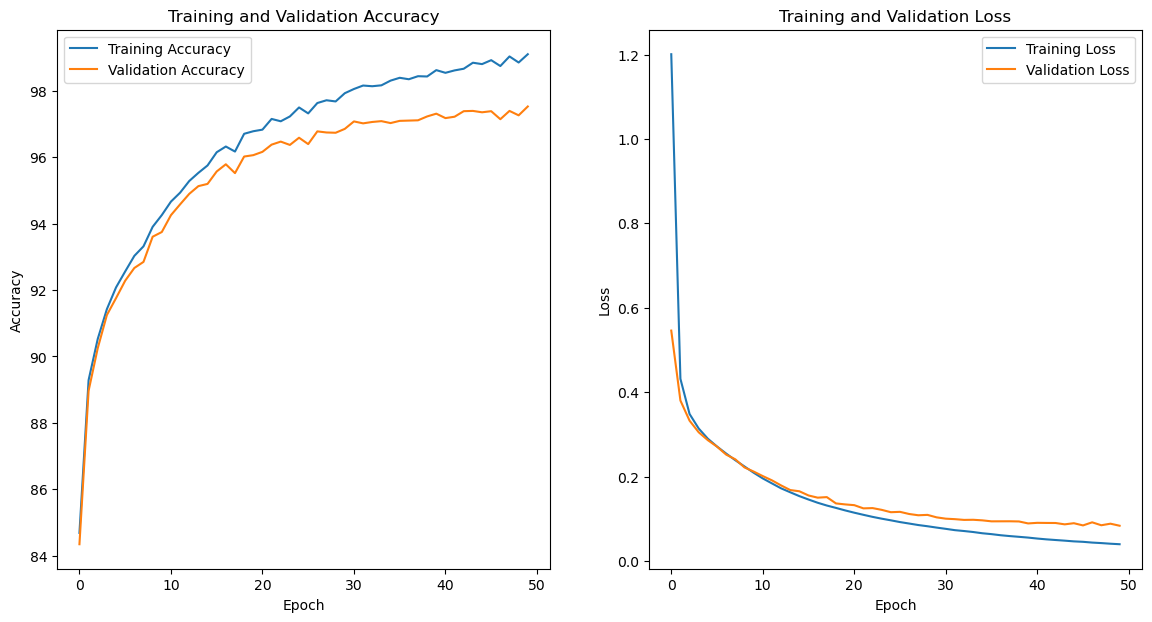

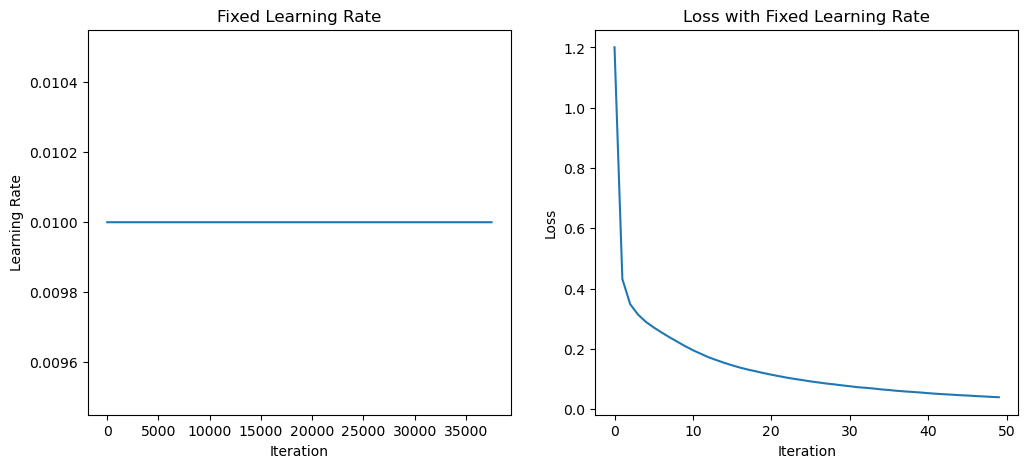

In [18]:
fixed_lr = 0.01
model = SimpleNN().to(device)
optimizer = optim.SGD(model.parameters(), lr=fixed_lr)
train_loss_hist, val_loss_hist, train_acc_hist, val_acc_hist, fixed_lr_hist = train_model_with_early_stopping(model, optimizer)
plot_accuracy_loss(train_acc_hist, val_acc_hist, train_loss_hist, val_loss_hist)
plot_results(fixed_lr_hist, train_loss_hist, 'Fixed Learning Rate', 'Loss with Fixed Learning Rate')

# References

This notebook is adapted from or uses following sources:
* 